In [1]:
%pip install numpy
%pip install matplotlib
%pip install pytubefix
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

In [3]:
from pytubefix import YouTube
import os

link = 'https://www.youtube.com/watch?v=WPDpgSBEWaI'

yt = YouTube(link)

file = yt.streams.filter(only_audio=True).first()
name = file.title

m4apath = os.path.join('m4a/', name + '.m4a')
wavpath = os.path.join('wav/', name + '.wav')

In [4]:
import subprocess

download = False

if download:
    file.download(output_path= 'm4a/')
    print('Video downloaded successfully!')

    subprocess.call(['ffmpeg', '-i', m4apath,
                    wavpath])
        

In [5]:
from scipy.io import wavfile

sampleRate, data = wavfile.read(wavpath)

sampleLen = data.shape[0]
numChannels = data.shape[1]

timeLength = sampleLen / sampleRate

samples = np.empty((numChannels, sampleLen), np.int16)

for i in range(sampleLen):
    for j in range(numChannels):
        samples[j][i] = data[i][j]


In [6]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600


In [7]:
def plotSignal(arrayX, arrayY, numChannels):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)

    ax.plot(arrayX, arrayY[0], linewidth = 0.5, color = 'purple')
    if numChannels == 2:
        ax.plot(arrayX, arrayY[1], linewidth = 0.5, color = 'blue')

    plt.show()

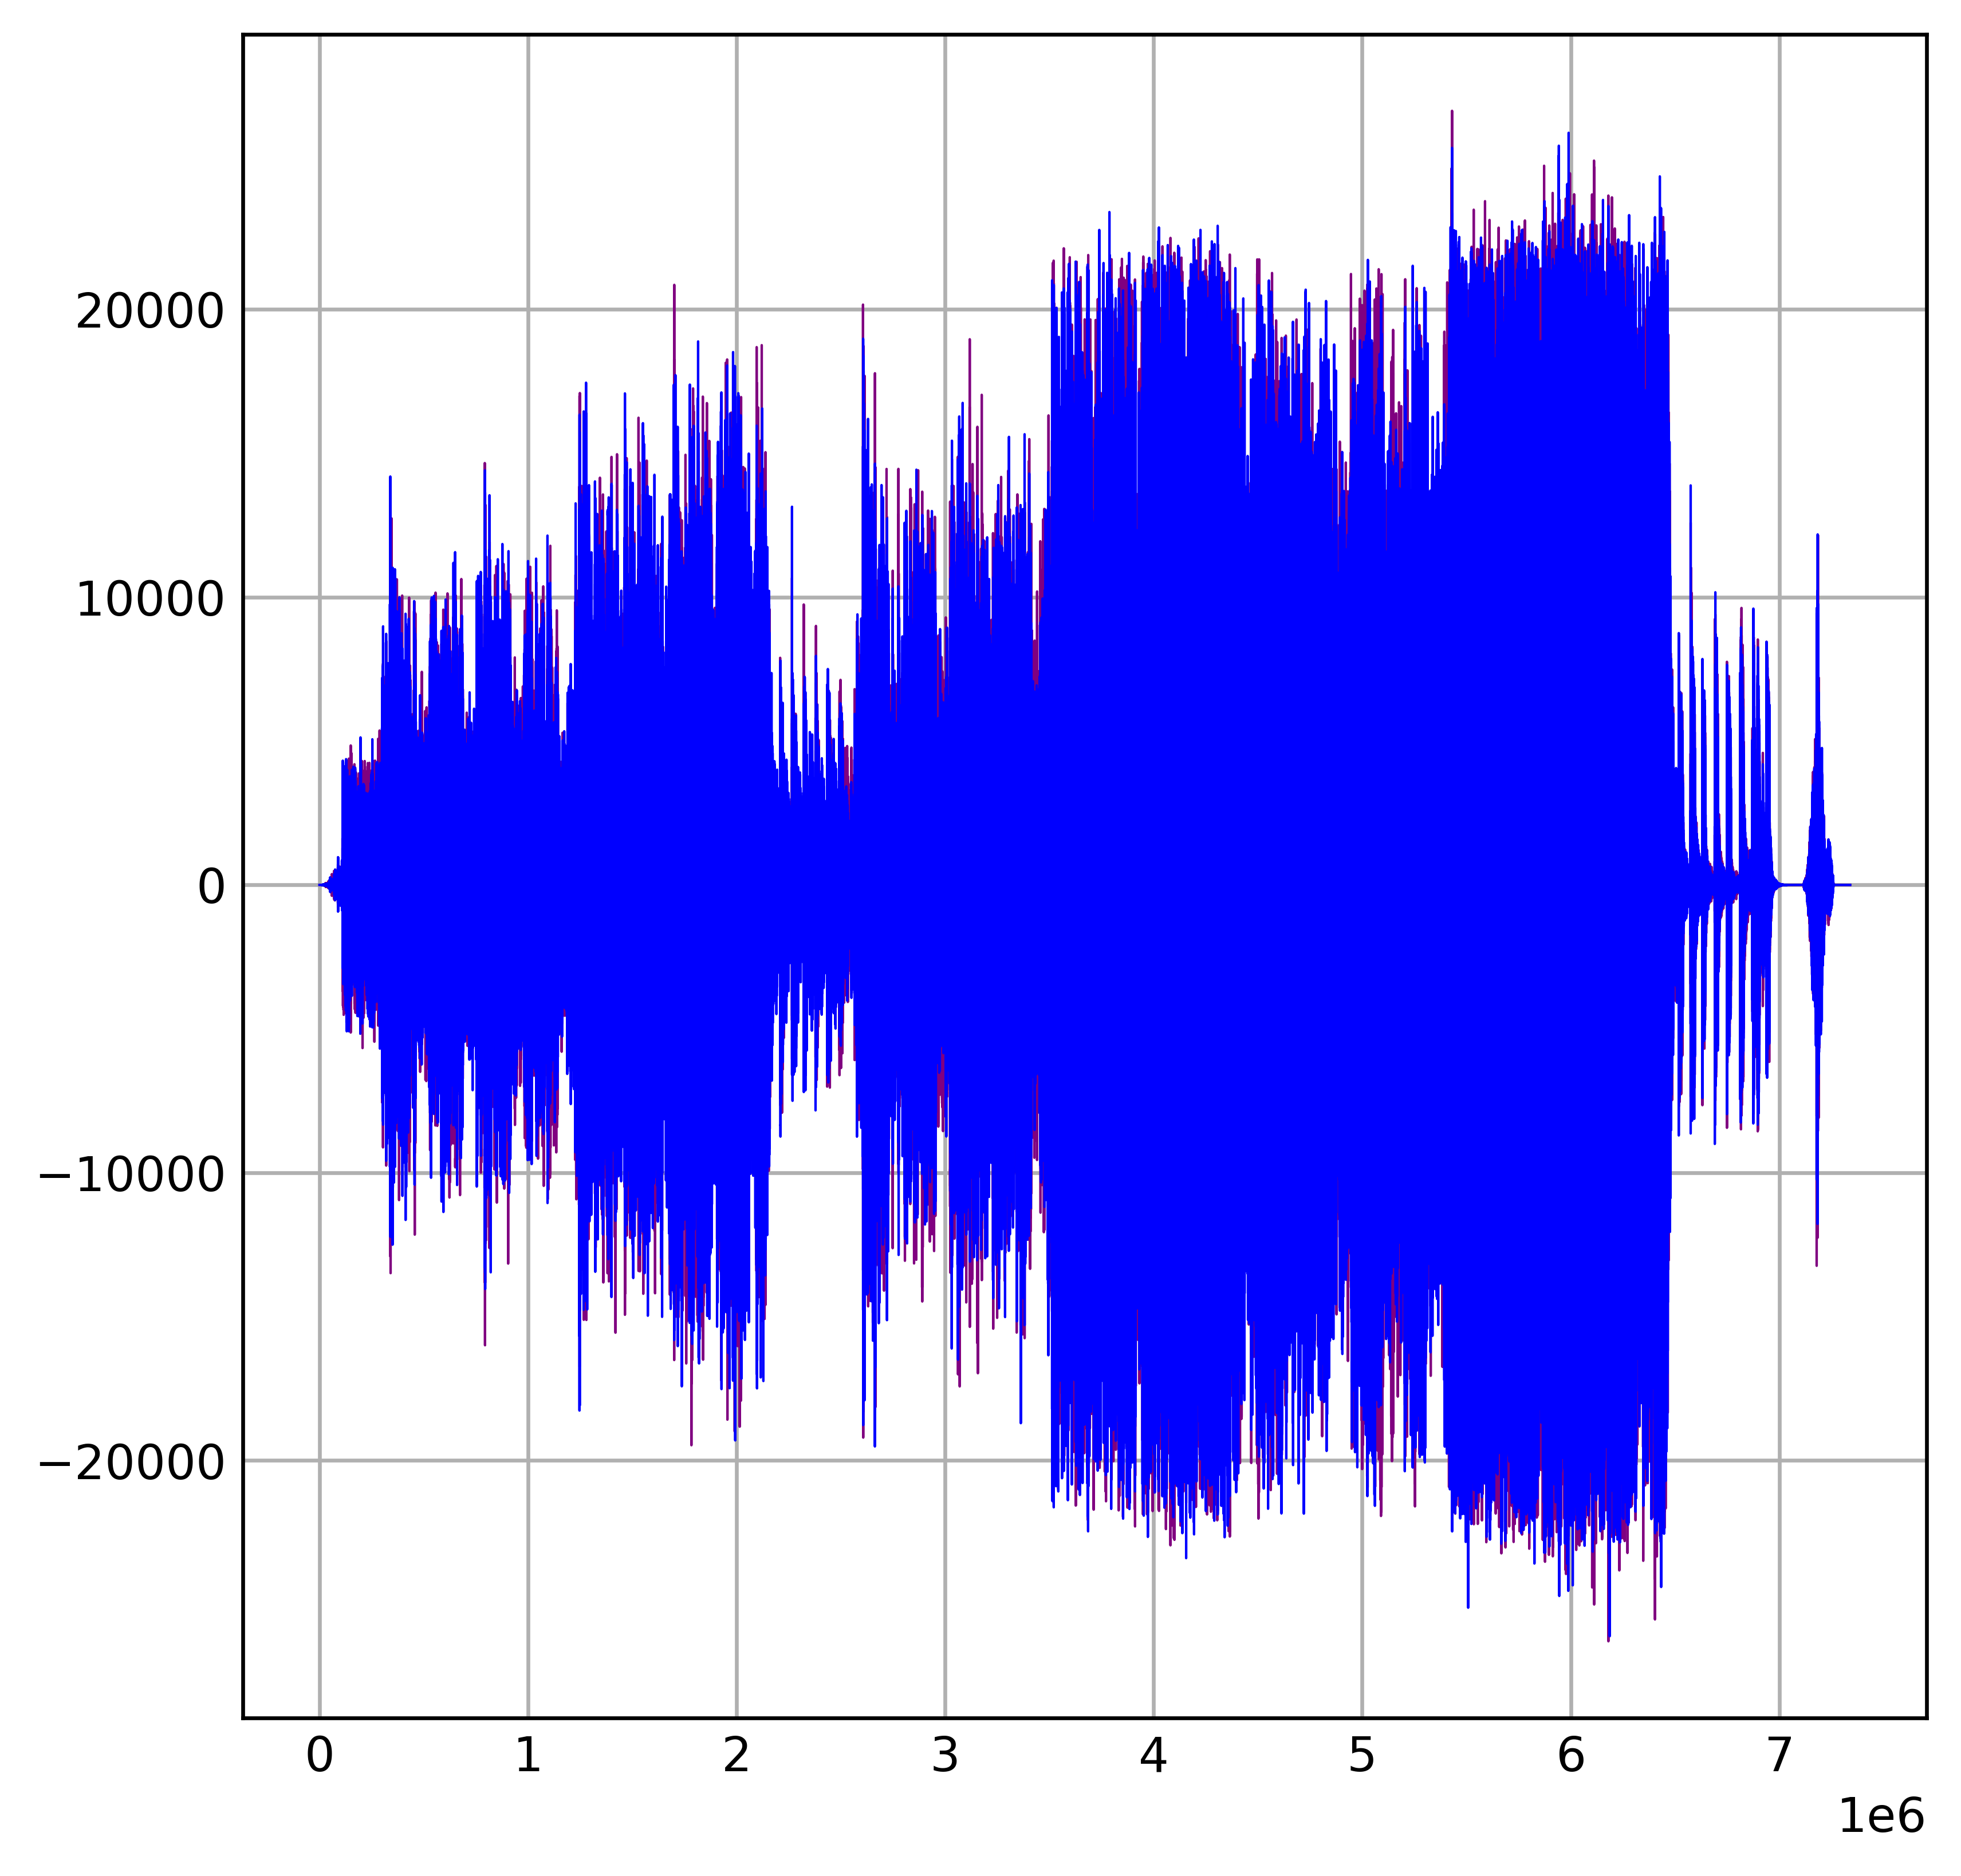

In [8]:
plotSignal(range(sampleLen), samples, numChannels)

In [9]:
from scipy.fft import fft, ifft

if numChannels == 2:
    fourier = [fft(samples[0]), fft(samples[1])]
else:
    fourier = [fft(samples[0])]


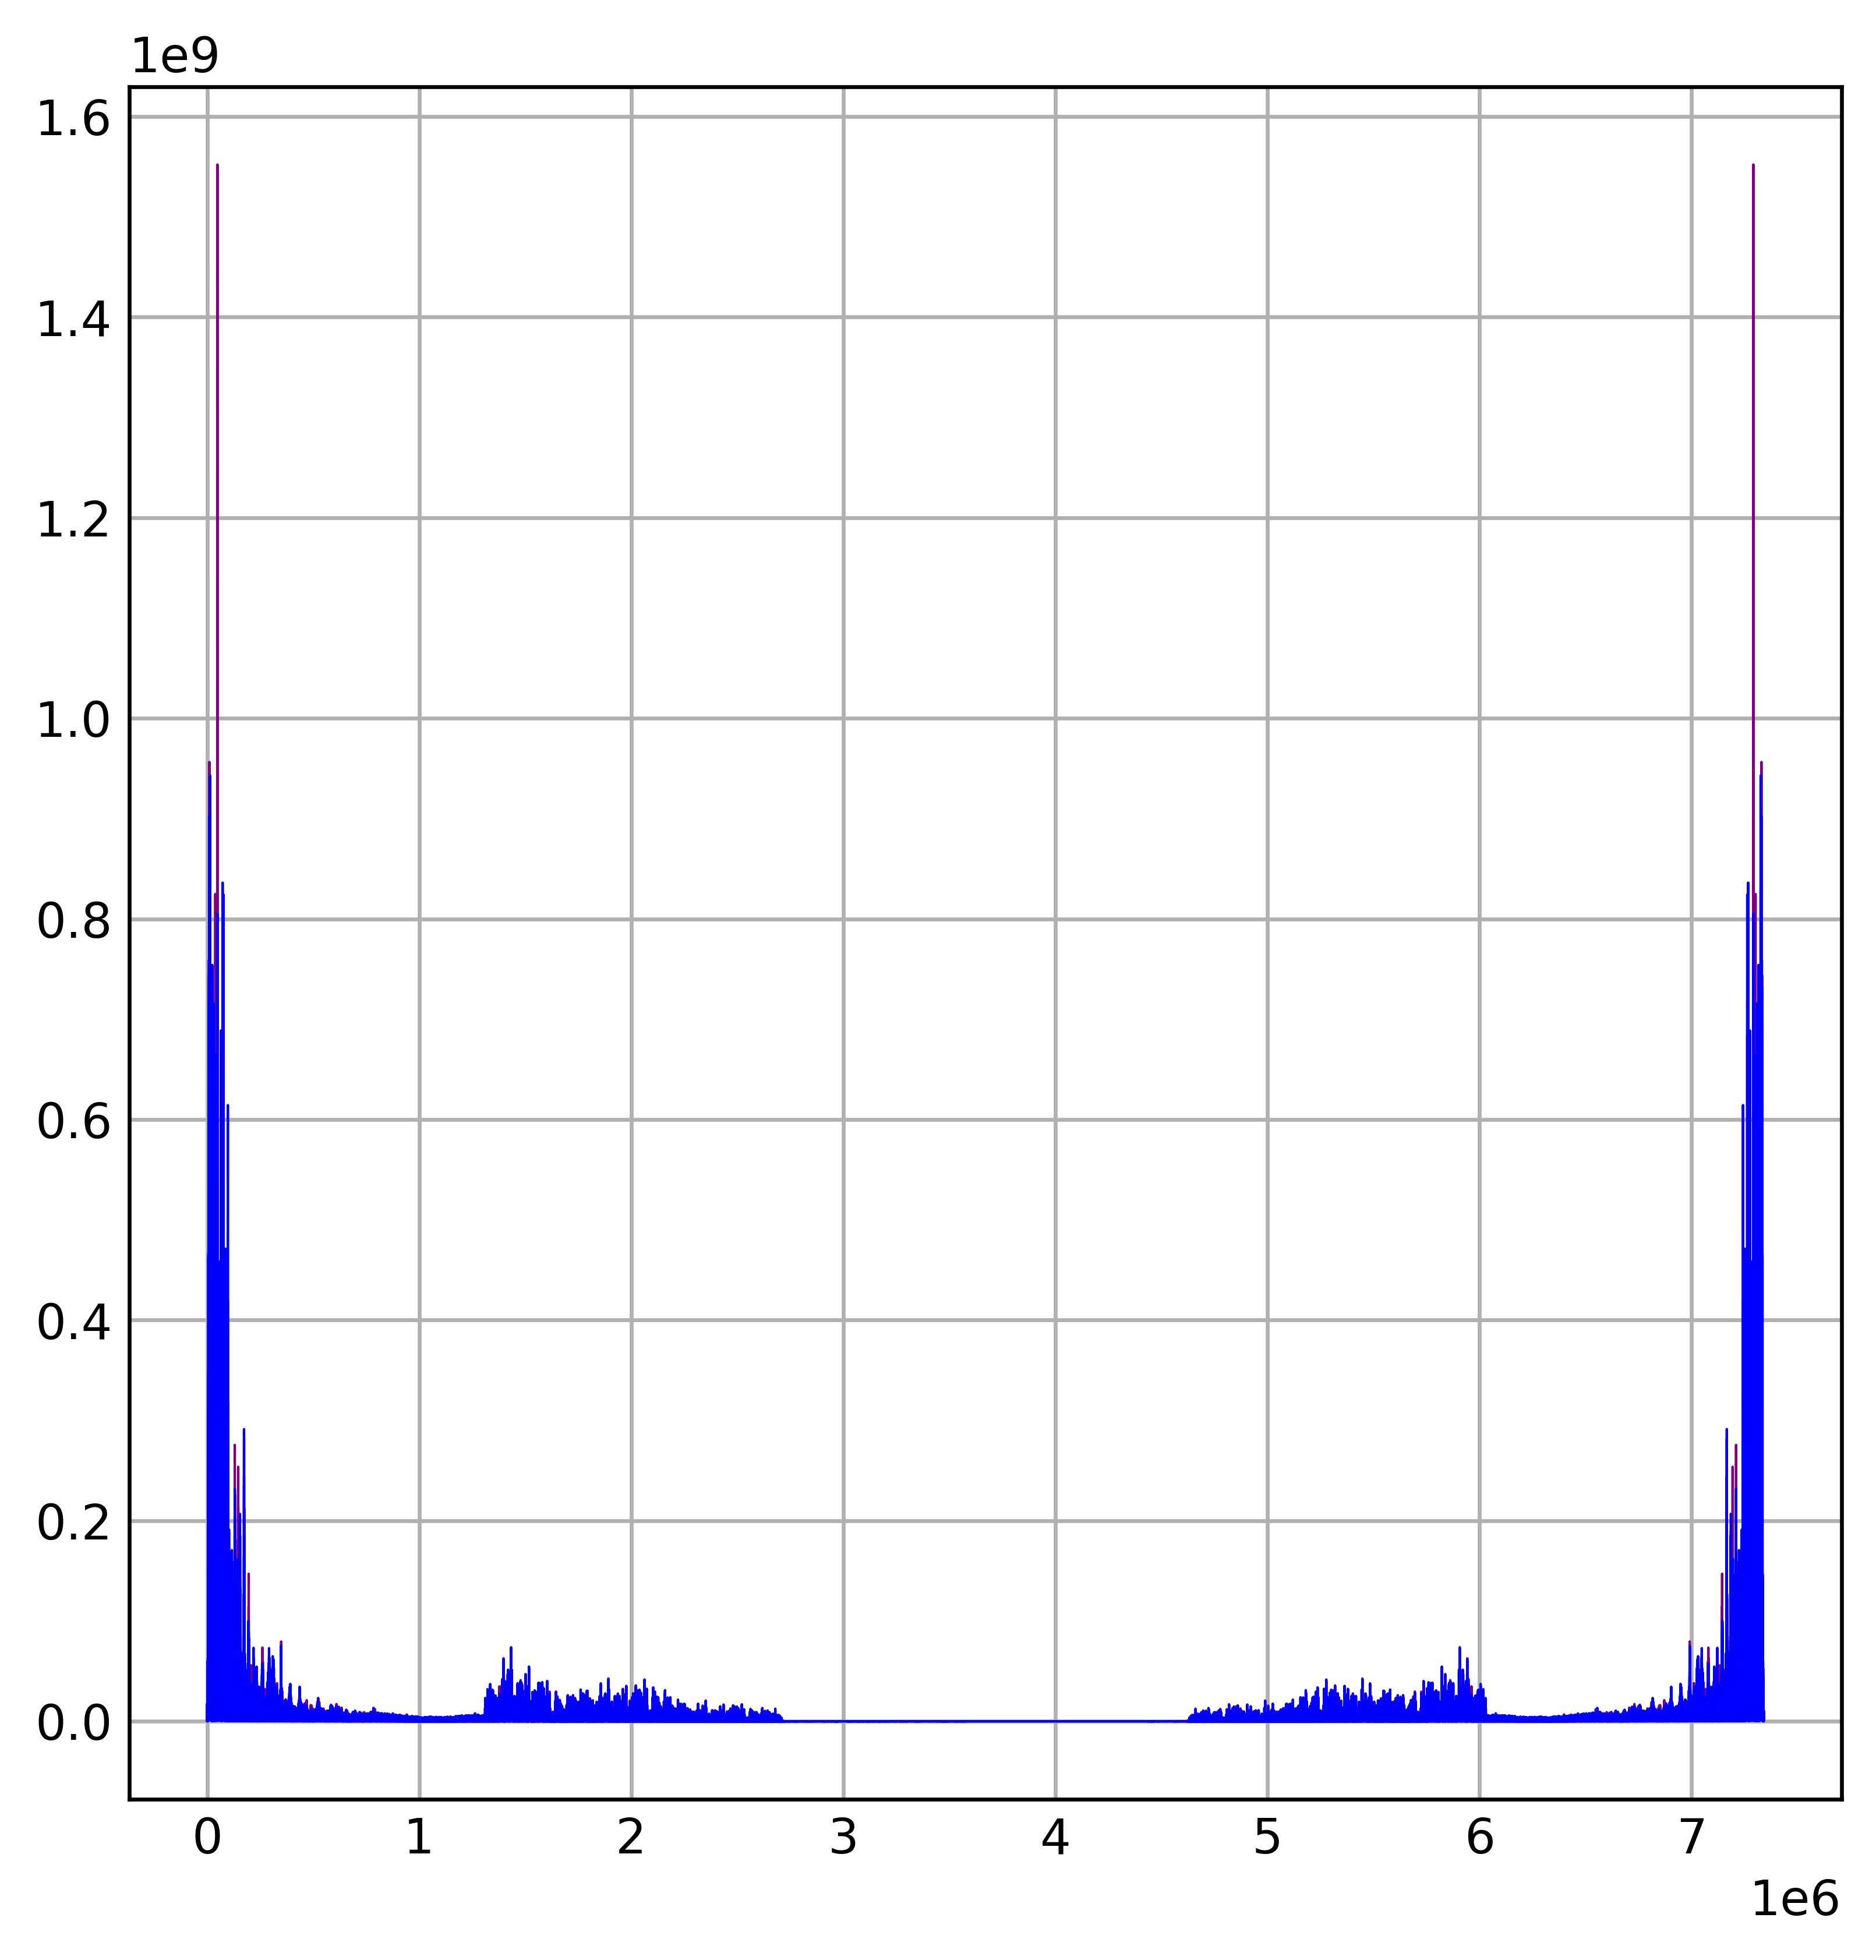

In [10]:
plotSignal(range(sampleLen), np.abs(fourier), numChannels)

In [11]:
correctedSampleLen = int(sampleLen / 2)

freqArray = np.empty((correctedSampleLen ,1), np.float64)

for i in range(correctedSampleLen):
    freqArray[i] = i / timeLength


In [12]:
def correctRealFourier(signal, crrSampleLen, dim):
    result = np.empty((dim, crrSampleLen), np.complex128)
    tempSampleLen = crrSampleLen * 2

    for i in range(dim):
        for j in range(crrSampleLen):
            result[i][j] = signal[i][j] + signal[i][tempSampleLen - j - 1]
    
    return result

In [13]:
correctedFourier = correctRealFourier(fourier, correctedSampleLen, numChannels)

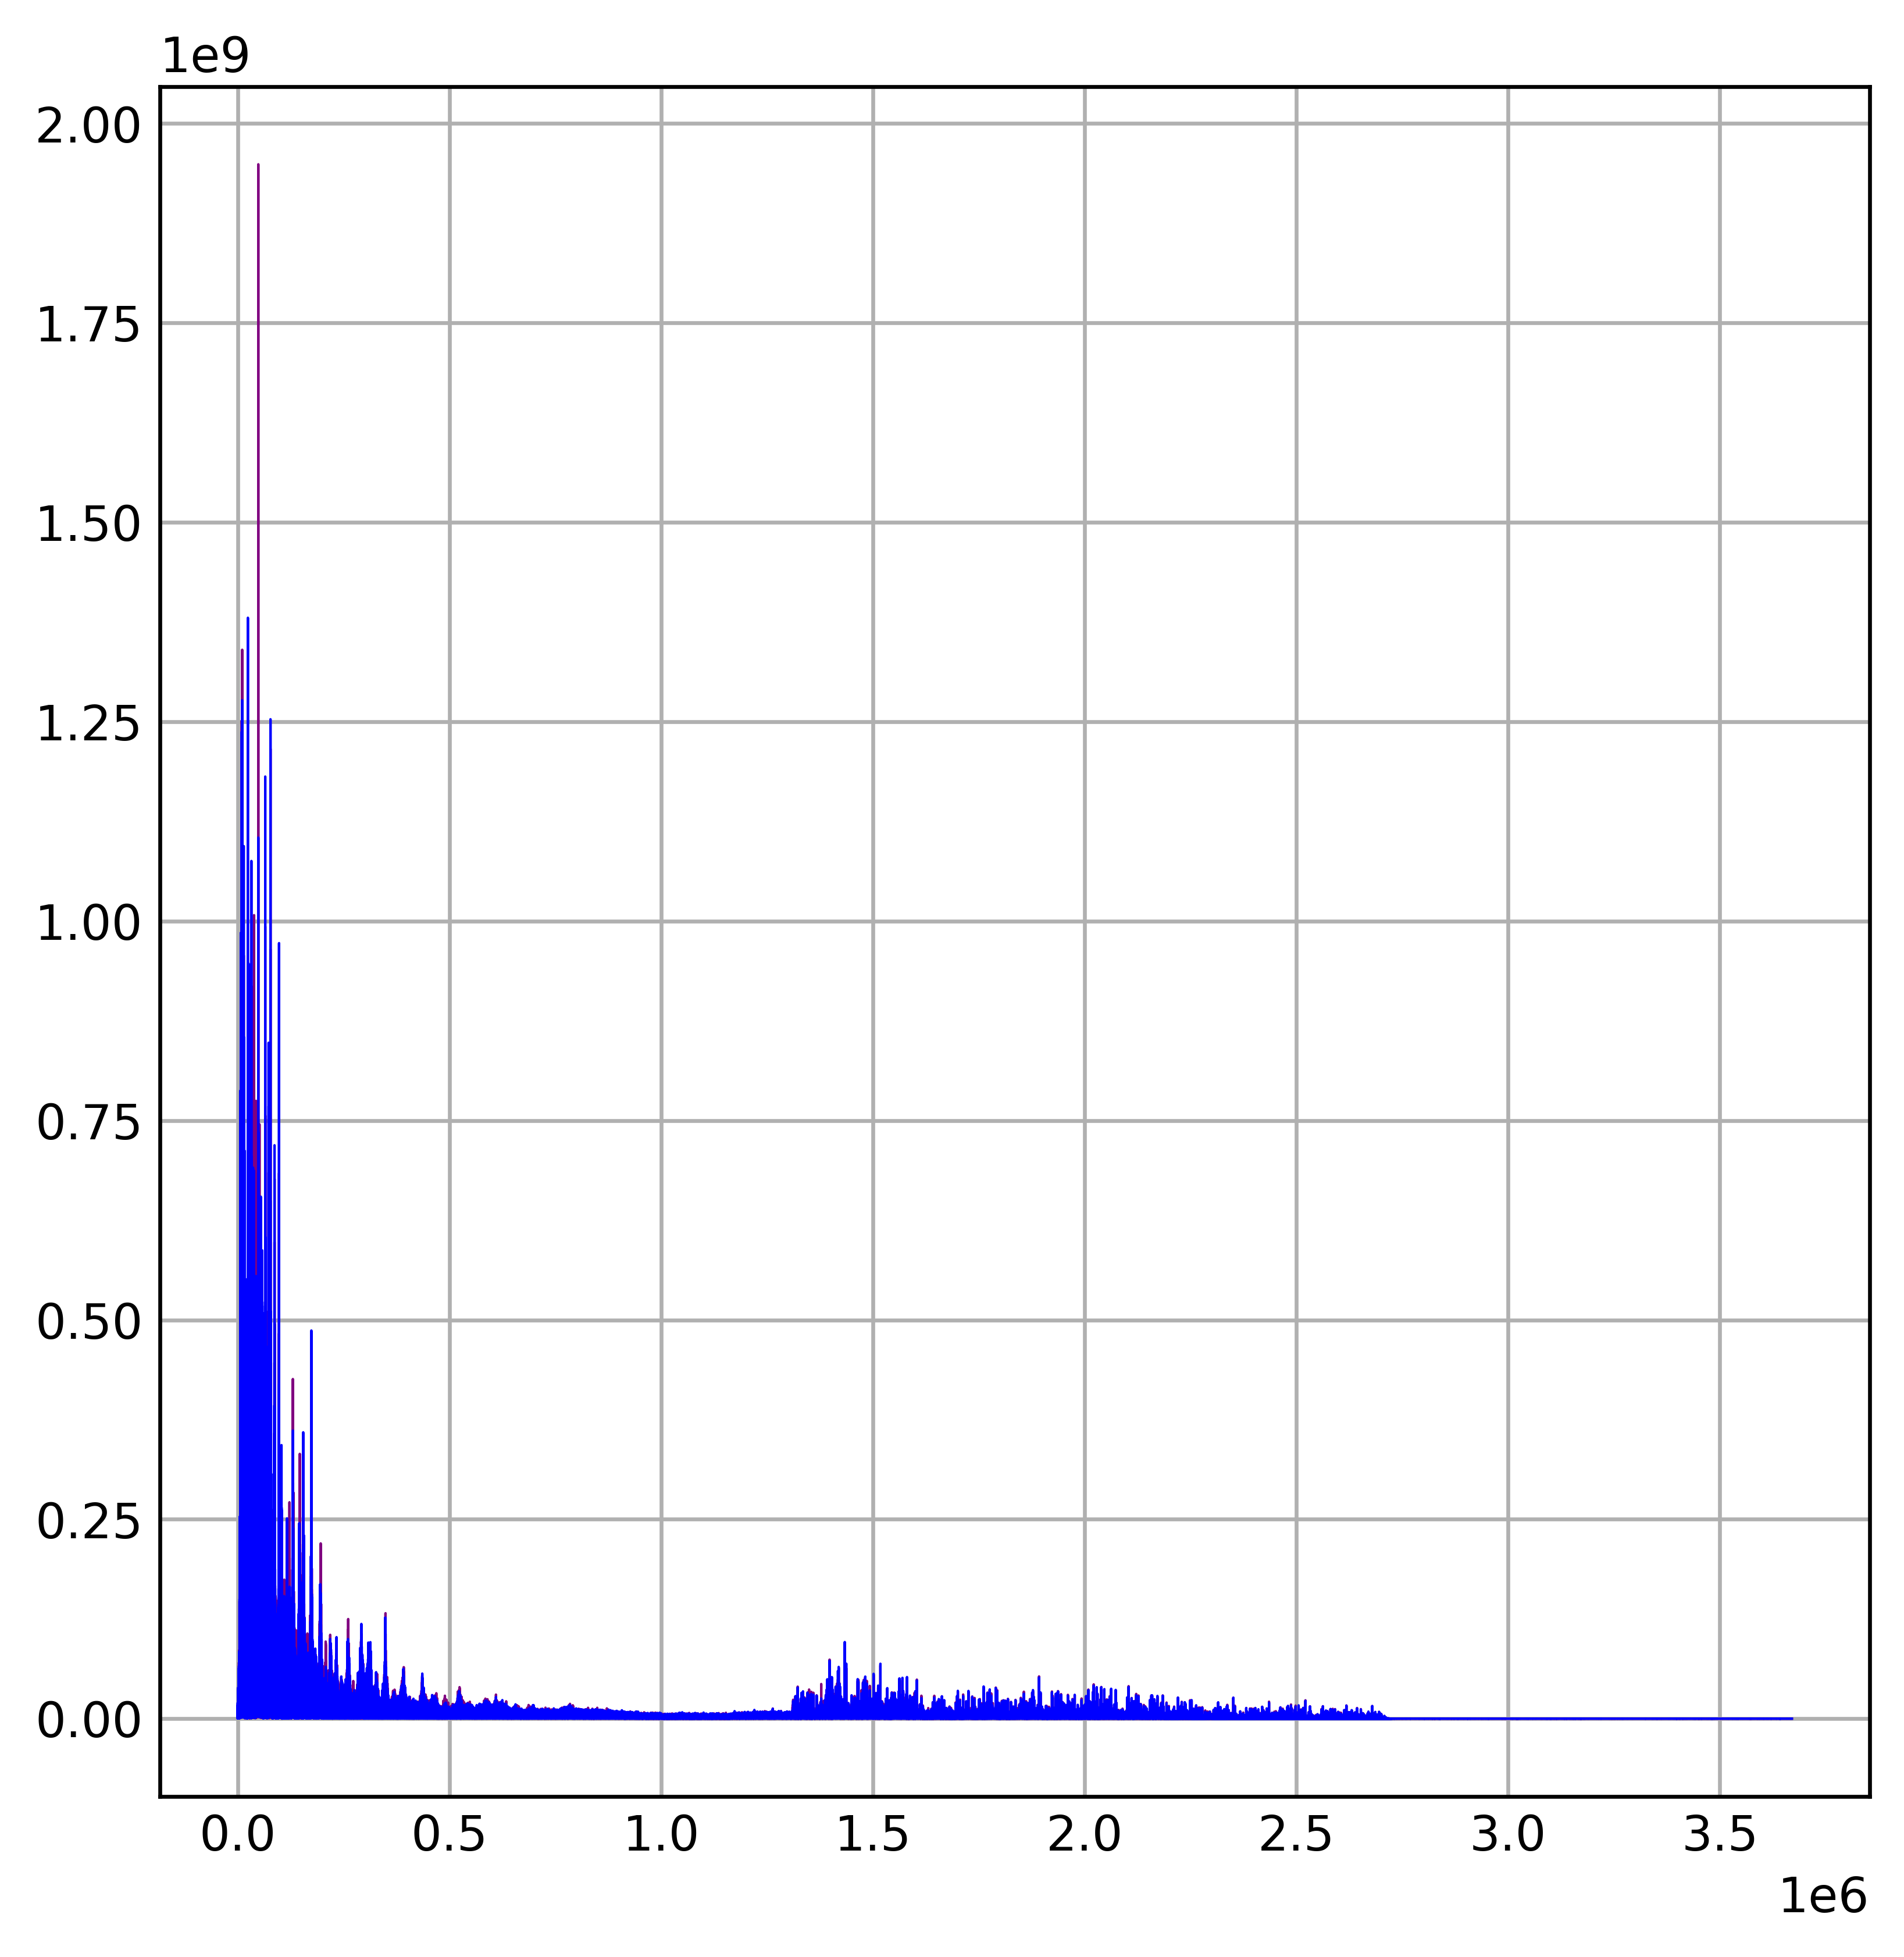

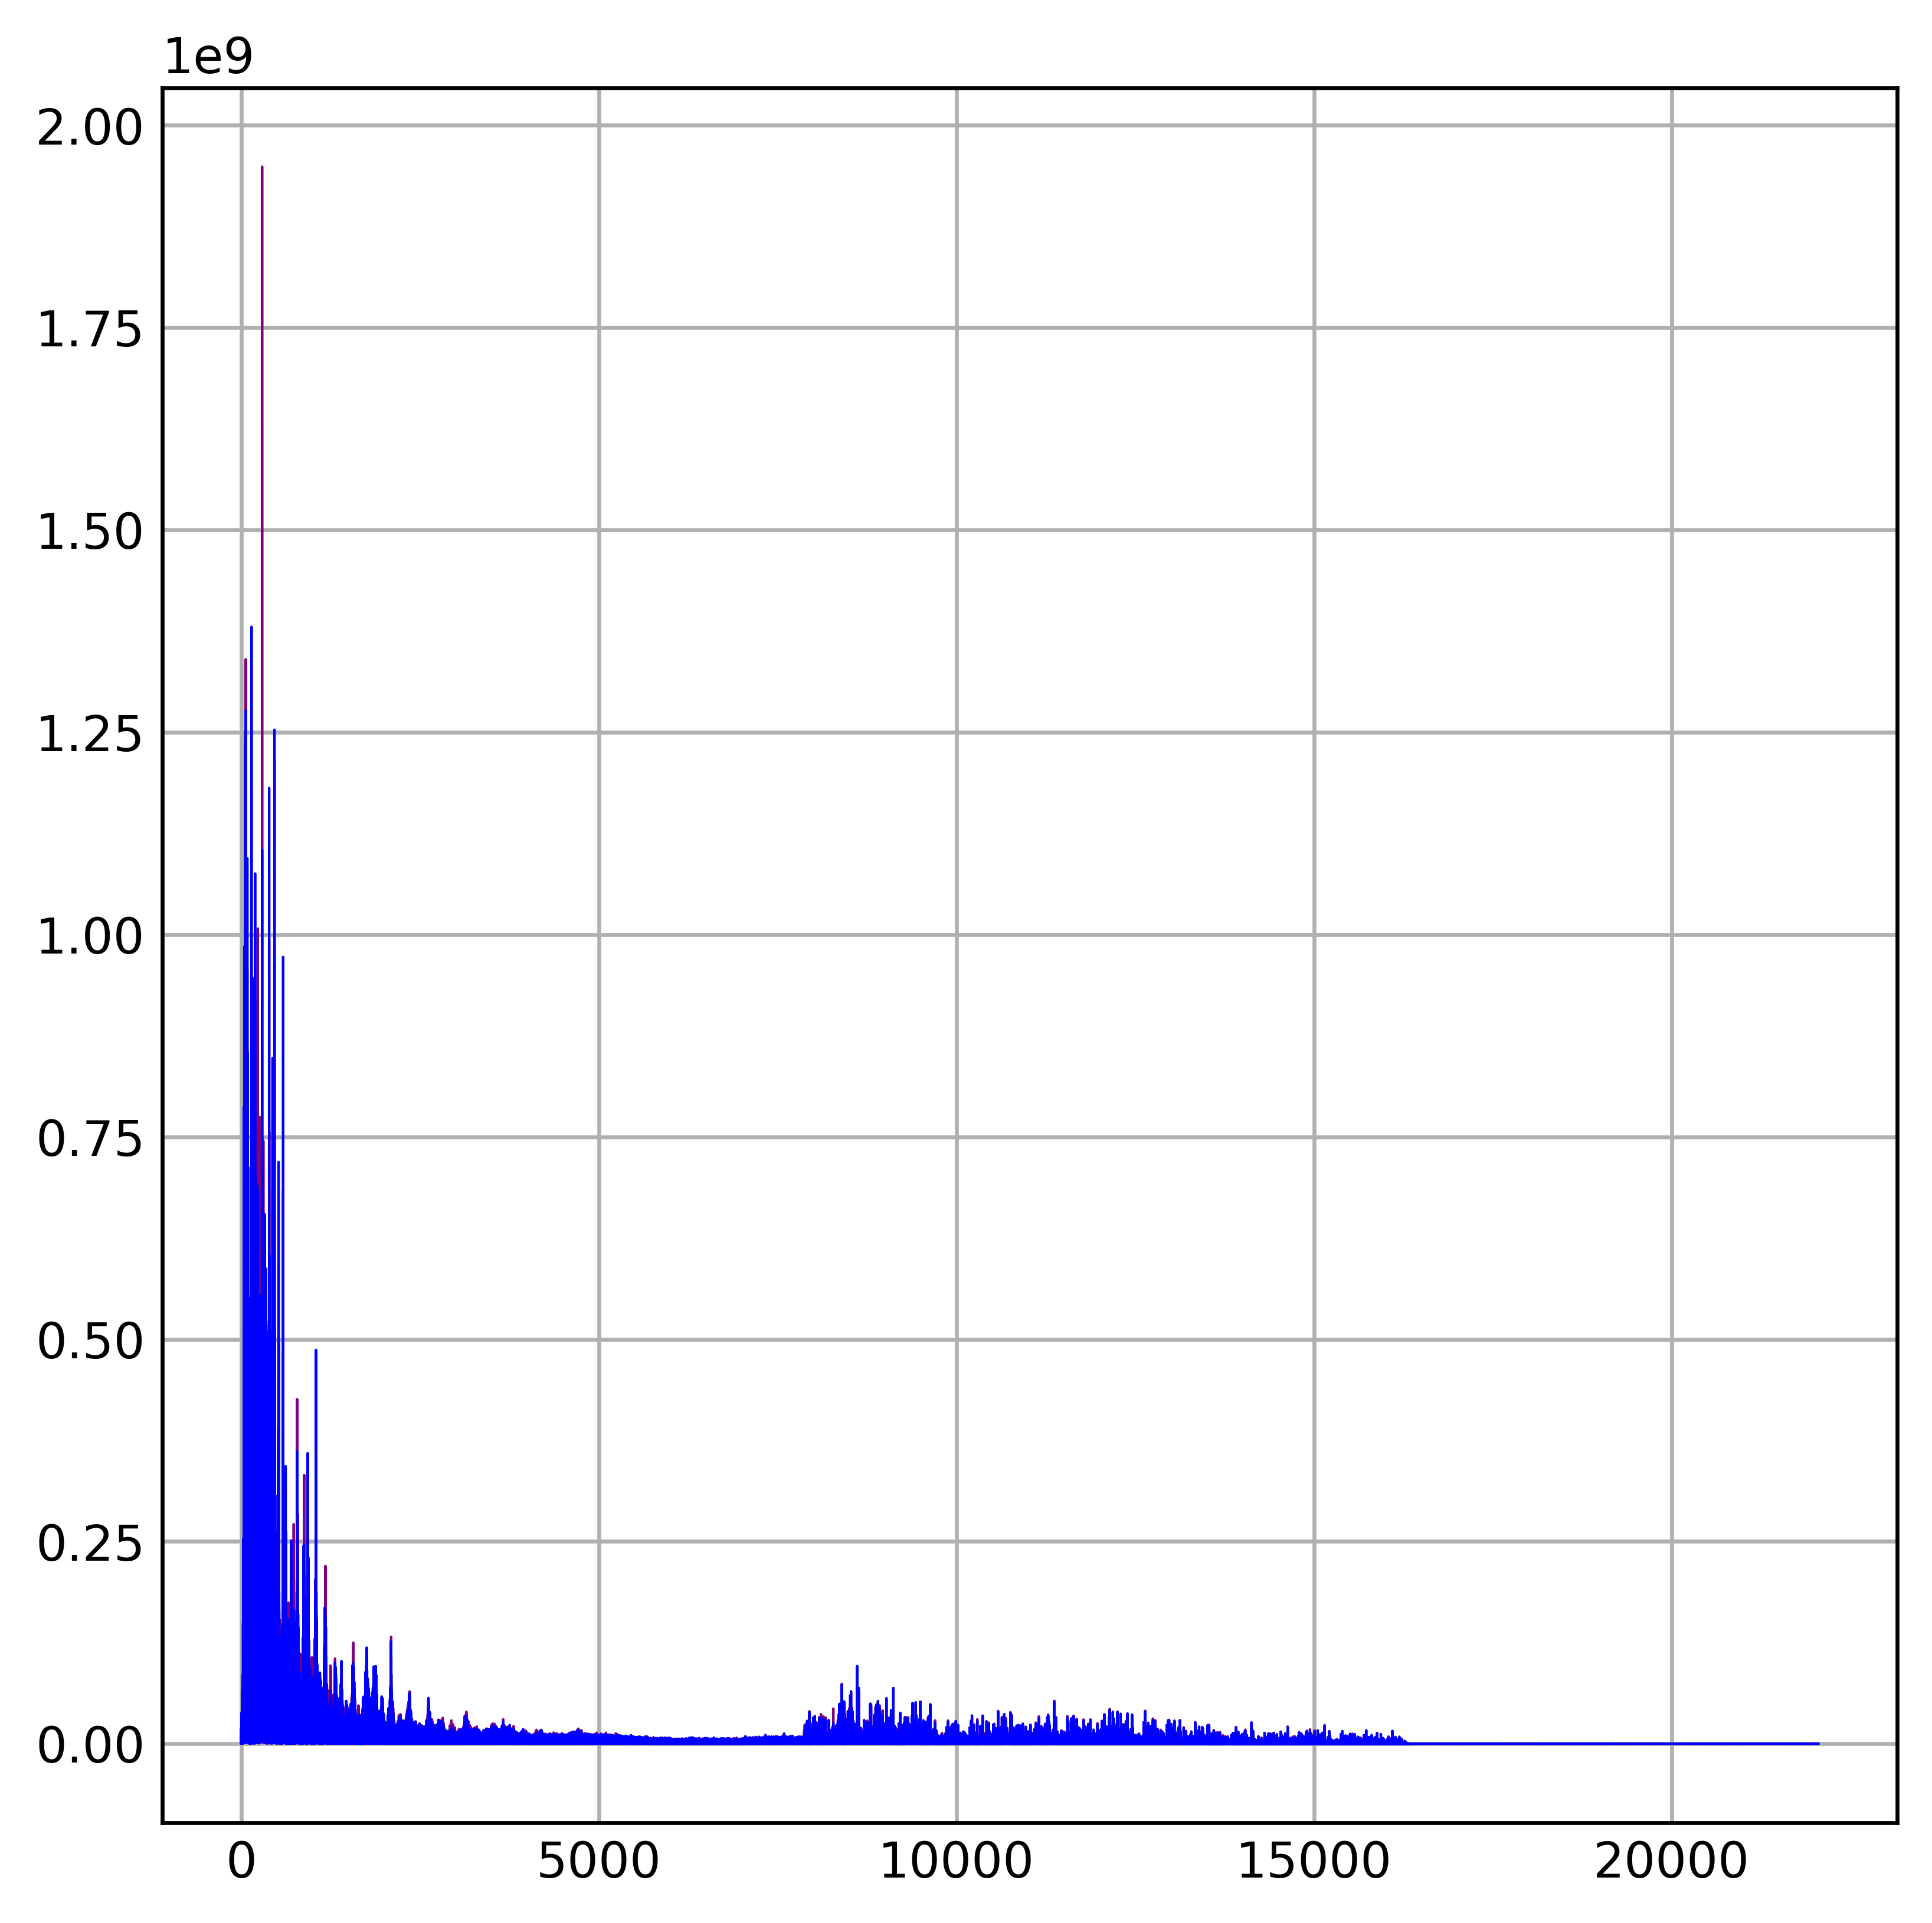

In [14]:
plotSignal(range(correctedSampleLen), abs(correctedFourier), numChannels)
plotSignal(freqArray, abs(correctedFourier), numChannels)

In [15]:
def amplify(signal, freqs, start, end, scale, dim, crrSampleLen):
    tempSampleLen = crrSampleLen * 2 
    result = np.empty((dim, tempSampleLen), np.complex128)

    for i in range(dim):
        for j in range(crrSampleLen):
            if freqs[j] >= start and freqs[j] <= end:
                result[i][j] = signal[i][j] * scale
                result[i][tempSampleLen - j - 1] = signal[i][tempSampleLen - j - 1] * scale
            else:
                result[i][j] = signal[i][j]
                result[i][tempSampleLen - j - 1] = signal[i][tempSampleLen - j - 1]

    return result

In [16]:
amplifiedFourier = amplify(fourier, freqArray, 1000, 5000, 0.25, numChannels, correctedSampleLen)
correctedAmplifiedFourier = correctRealFourier(amplifiedFourier, correctedSampleLen, numChannels)

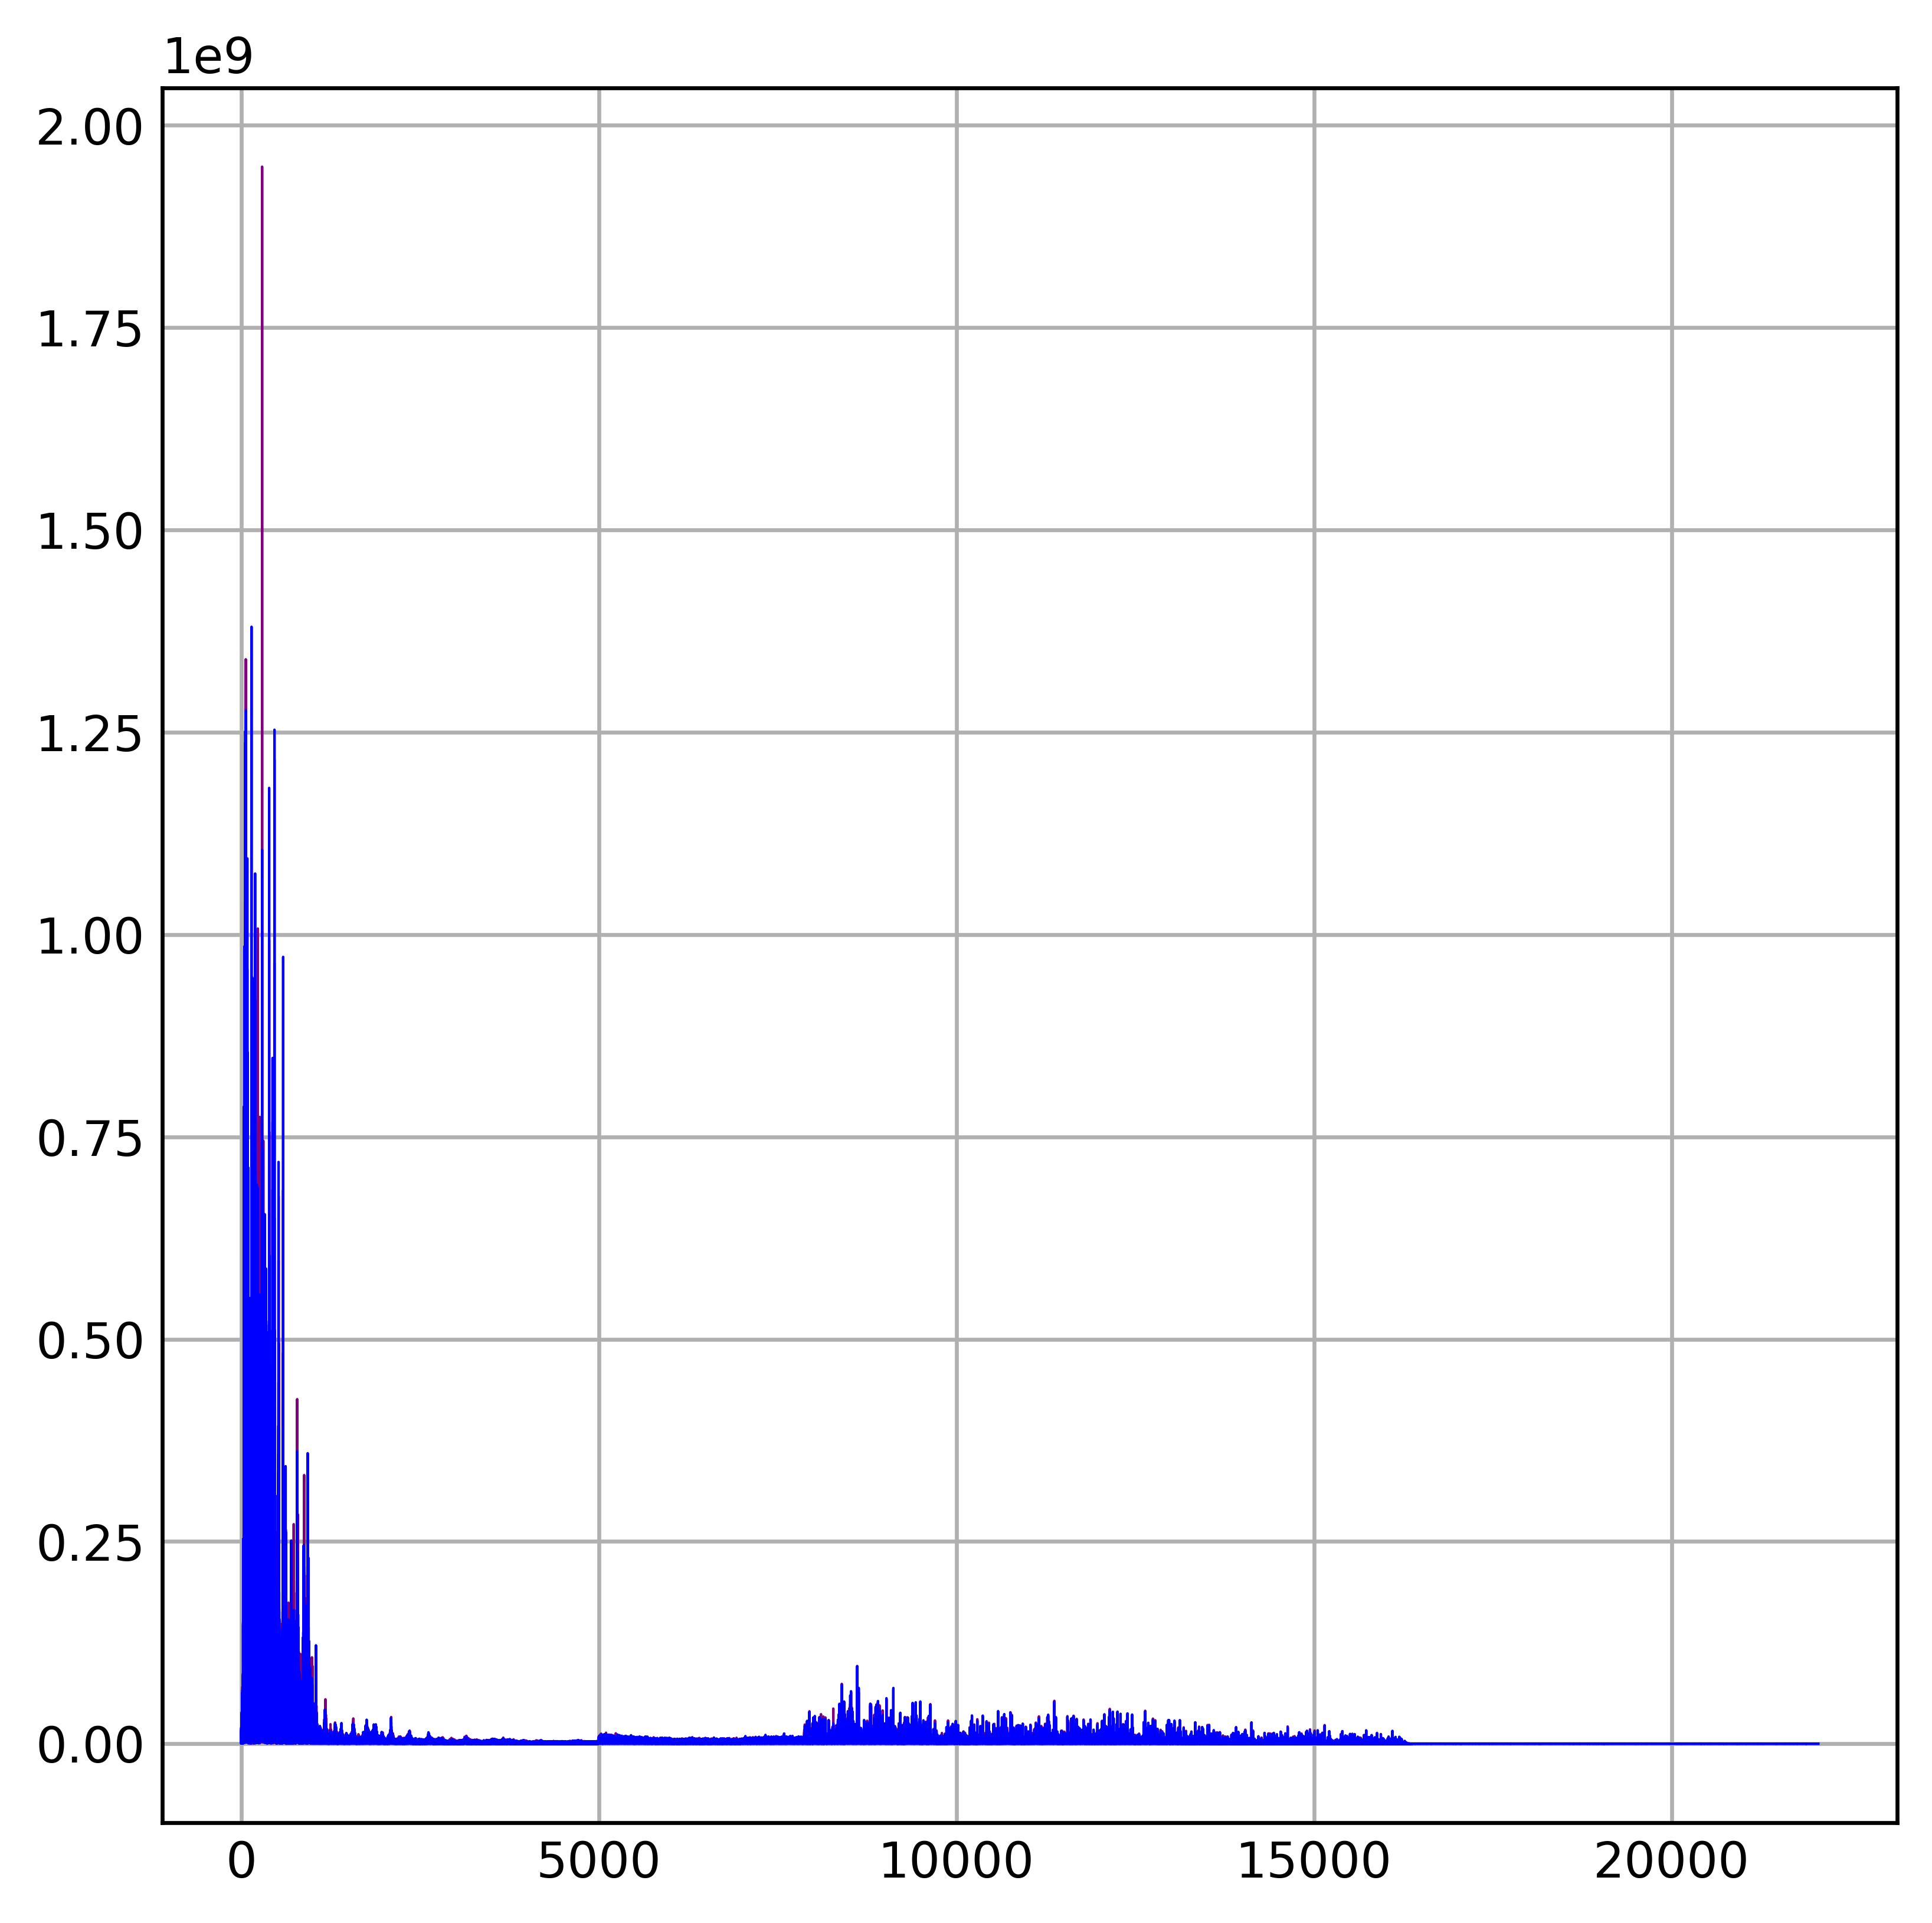

In [17]:
plotSignal(freqArray, abs(correctedAmplifiedFourier), numChannels)

In [18]:
if numChannels == 2:
    amplifiedSamples = np.array([np.real(ifft(amplifiedFourier[0])), np.real(ifft(amplifiedFourier[1]))], np.int16)
else:
    amplifiedSamples = np.array([np.real(ifft(amplifiedFourier[0]))], np.int16)


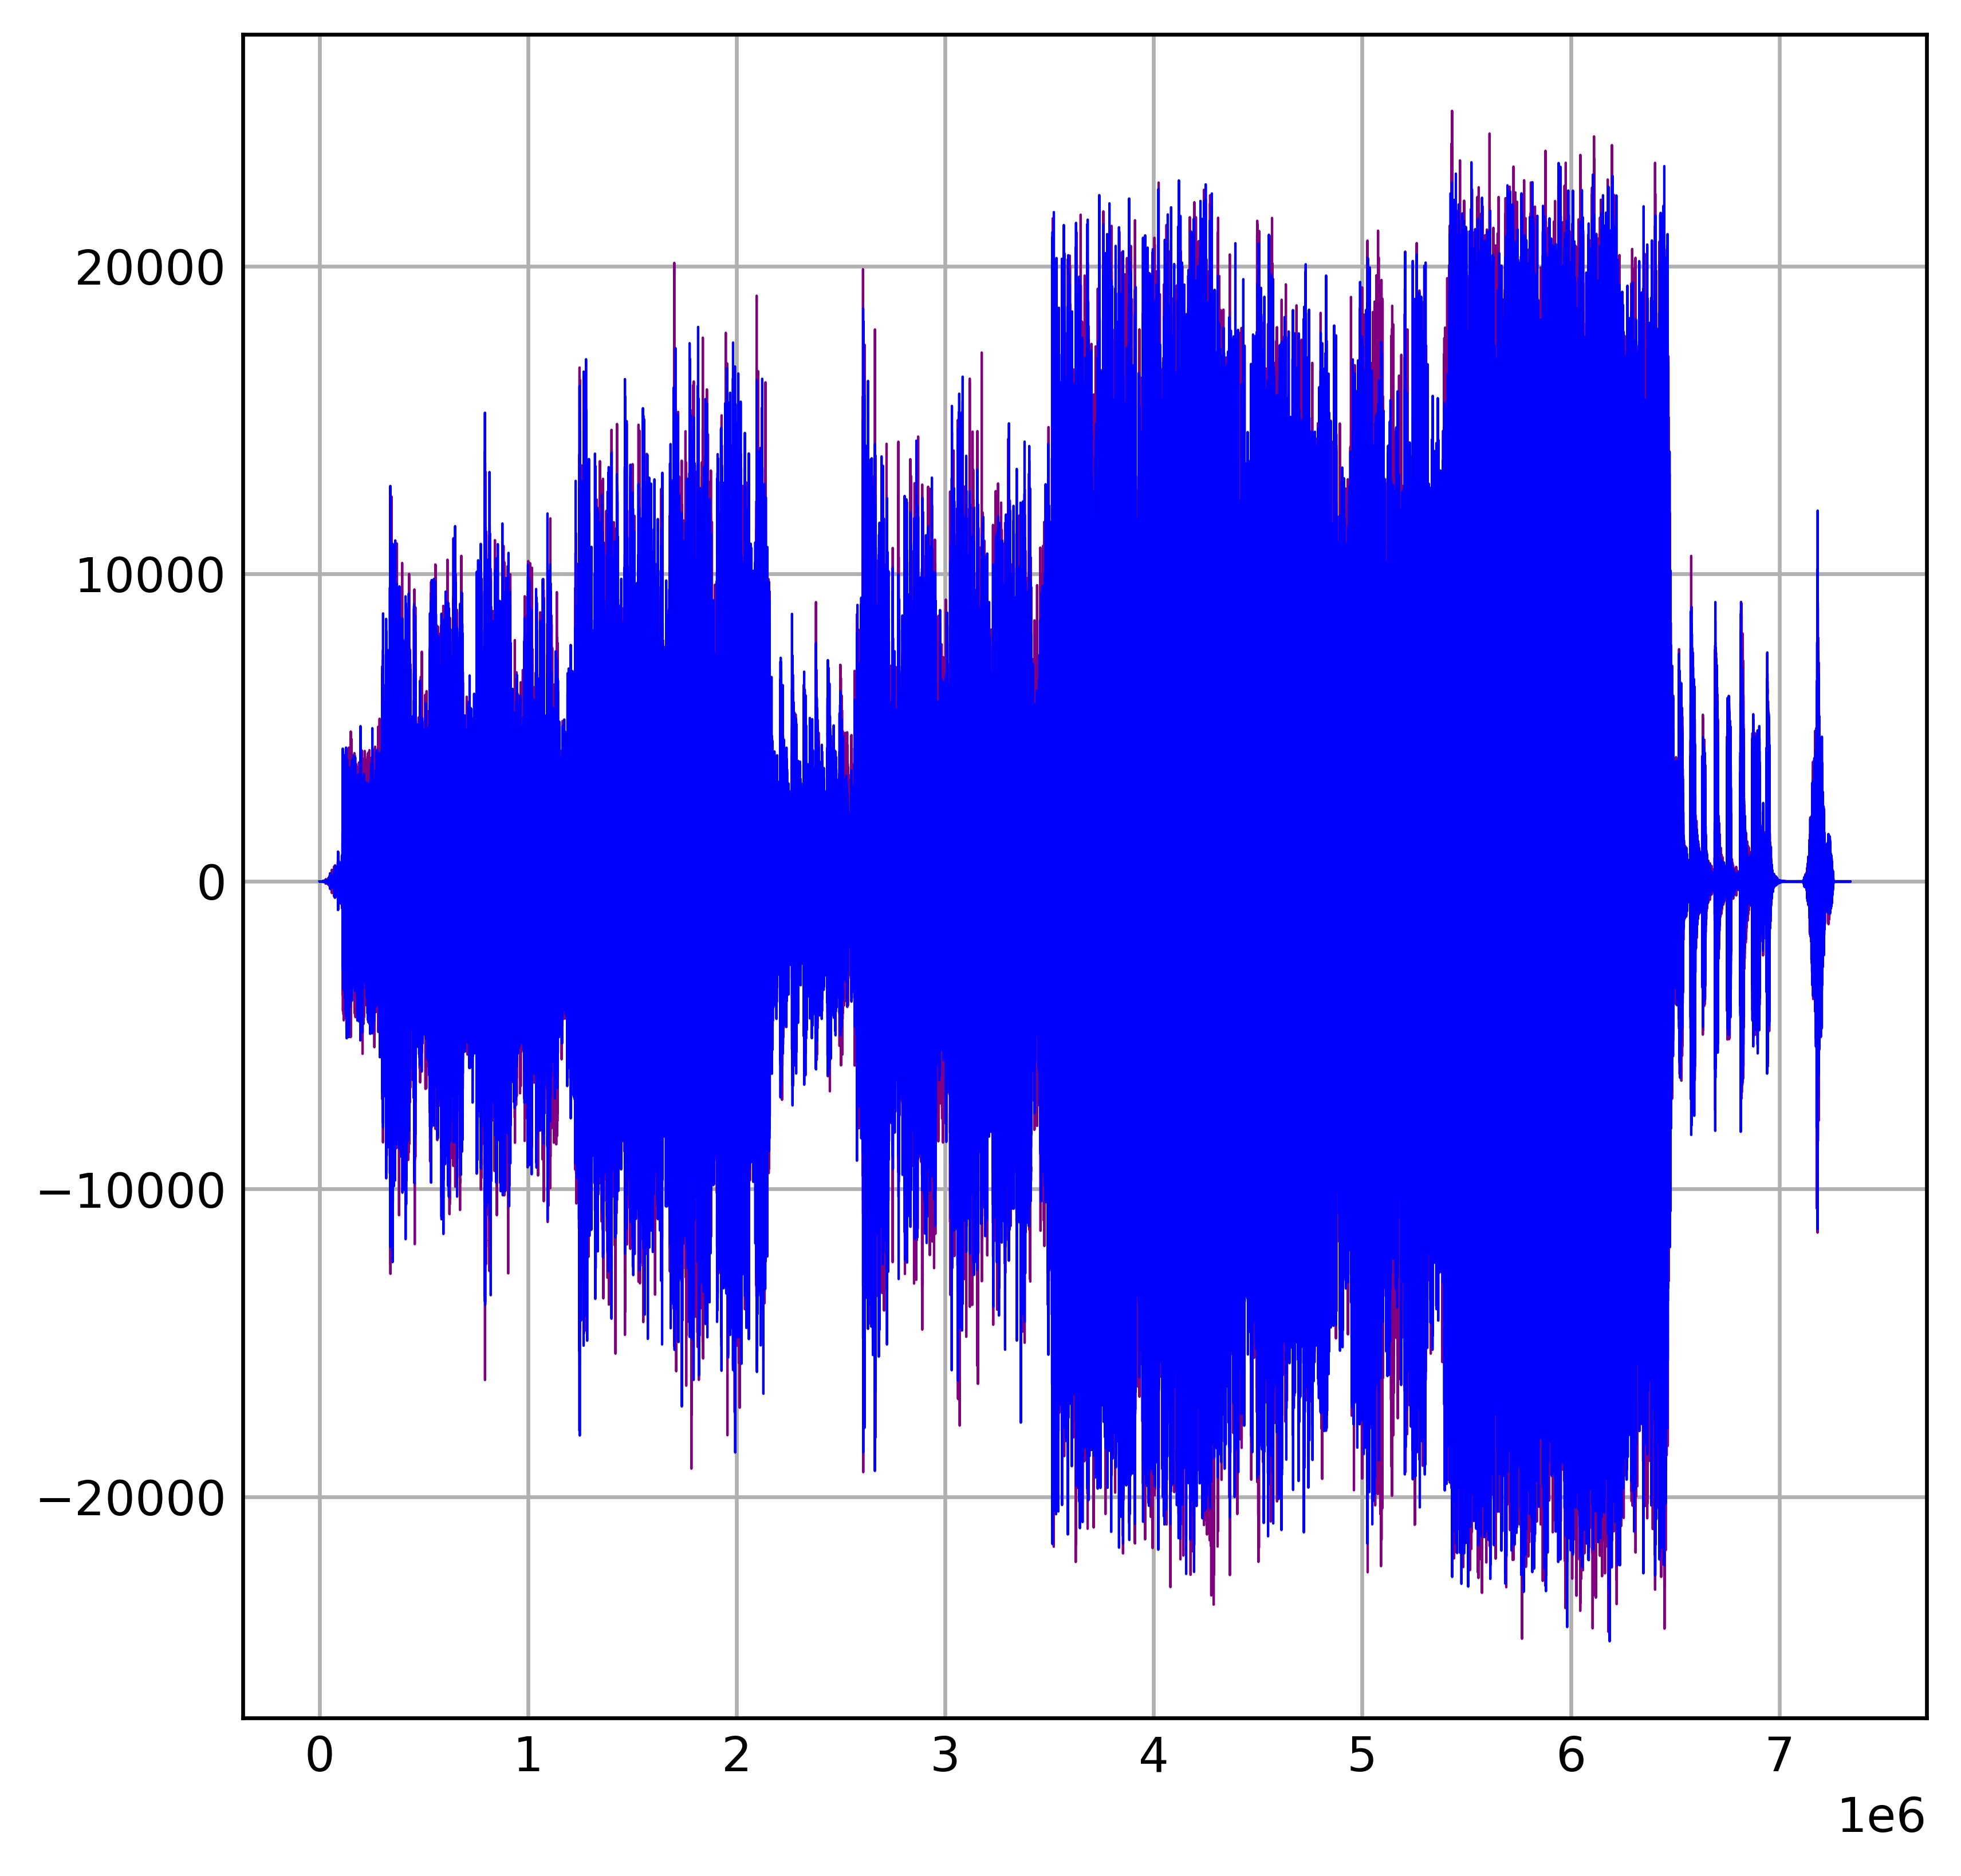

In [19]:
plotSignal(range(sampleLen), amplifiedSamples, numChannels)

In [20]:
resultwavPath = os.path.join('resultwav/', name + '.wav')

if not amplifiedSamples.shape[1] <= 2:
    amplifiedSamples = amplifiedSamples.transpose()

wavfile.write(resultwavPath, sampleRate, amplifiedSamples)